In [13]:
# Importing Libraries and datasets
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("../dataset/raw/train.csv")
test_df = pd.read_csv("../dataset/raw/test.csv")

color_pallete = ["#bd6969", "#69bd78"]

In [14]:
# Creating a new feature from 'PassengerId' feature
train_df["PassengerId"].head().to_frame()

,PassengerId
0,0001_01
1,0002_01
2,0003_01
3,0003_02
4,0004_01


### How will we do feature engineering on PassengerId
We know that each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number of people within the group. So we can create two new features, one will indicate total number of members present in each group, and the other indicating whether the passenger is travelling solo or in a group

In [15]:
# Creating new feature
def passengerid_new_features(df):
        # Splitting Group and Member values from "PassengerId" column
        df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
        df["Member"] = df["PassengerId"].apply(lambda x: x.split("_")[1])

        # Grouping the "Group" feature with "member" feature to check which group is travelling with how many members
        members_per_group = df.groupby("Group")["Member"].count()
        
        #Creating a set of group values which are travelling with more than 1 members
        more_than_one = members_per_group[members_per_group > 1]

        # Creating a new feature "Solo" which will indicate whether the person is travelling solo or not.
        df["Travelling Solo"] = df["Group"].apply(lambda y: y not in more_than_one)

        # Creating a new feature "Group_size" which will indicate each group number of members.
        df["Group Size"] = 0
        for i in members_per_group.items():
                df.loc[df["Group"] == i[0], "Group Size"] = i[1]

        return df

In [16]:
passengerid_new_features(train_df)
passengerid_new_features(test_df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Member,Travelling Solo,Group Size
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,01,True,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,01,True,1
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,01,True,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,01,True,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,01,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,9266,02,False,2
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,9269,01,True,1
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,9271,01,True,1
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,9273,01,True,1


In [17]:
# We don't require Group & Member features any more so we will drop those feature from both datasets
train_df.drop(columns=["Group", "Member"], inplace=True)
test_df.drop(columns=["Group", "Member"], inplace=True)

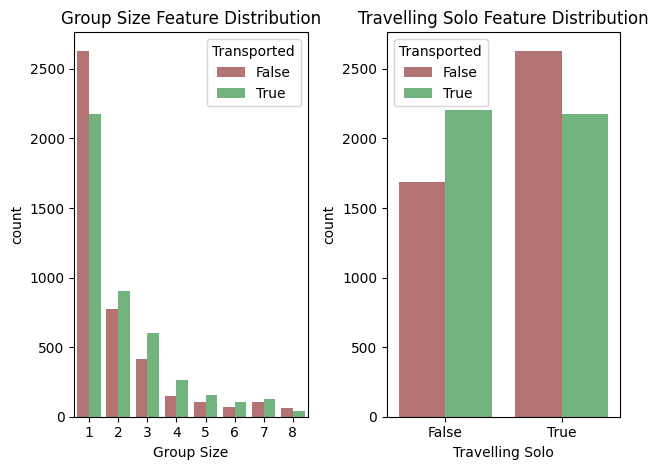

In [18]:
# Visualizing "Group_Size" & "Travelling_Solo" Features
plt.subplot(1, 2, 1)
sns.countplot(x="Group Size", hue="Transported", data=train_df, palette=color_pallete)
plt.title("Group Size Feature Distribution")
plt.tight_layout()
plt.subplot(1, 2, 2)
sns.countplot(x="Travelling Solo", hue="Transported", data=train_df, palette=color_pallete)
plt.title("Travelling Solo Feature Distribution")
plt.tight_layout()

### ⚠ Observations
From Group Size feature we can observe that most the passengers are travelling alone.
From Travelling Solo feature we can observe that passengers travelling solo are comparatively less transported when compared with passenger travelling in group.
Group sizes more than 1 are comparatively more transported when compared with passenger travelling solo

In [19]:
# Creating new feature using "Cabin" feature
train_df["PassengerId"].head().to_frame()

,PassengerId
0,0001_01
1,0002_01
2,0003_01
3,0003_02
4,0004_01


### How will we do feature engineering on Cabin
We know that cabin feature consists of deck/num/side, where deck is deck loacation, num is deck_number and side can be P for port or S for Starboard.
We can separate all these 3 values from cabin & create three new features: Cabin Deck, Cabin Number & Cabin Side.
We also know that Cabin feature is having NaN values so to avoid error while splitting we have to replace it in such a way taht we can split those NaN Values in all three new features respectively.

In [20]:
def cabin_new_feature(df):
    # Split NaN values into all three categories
    df["Cabin"].fillna(value="0/0/0", inplace=True)

    # Splitting Cabin Deck, Cabin Number & Cabin Side from "Cabin" column
    df["Cabin Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin Number"] = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Cabin Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])

    # Replace string missing values to numpy nan values
    cols = ["Cabin Deck", "Cabin Number", "Cabin Side"]
    df[cols] = df[cols].replace("0", np.nan) 

    # Filling Missing Values in new features created with the value that appears more often and median
    df["Cabin Deck"].fillna(df["Cabin Deck"].mode()[0], inplace=True)
    df["Cabin Number"].fillna(df["Cabin Number"].median(),inplace=True)
    df["Cabin Side"].fillna(df["Cabin Side"].mode()[0], inplace=True)

    return df

In [21]:
cabin_new_feature(train_df)
cabin_new_feature(test_df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Travelling Solo,Group Size,Cabin Deck,Cabin Number,Cabin Side
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,True,1,G,3,S
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,True,1,F,4,S
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,True,1,C,443.0,S
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,True,1,C,1,S
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,True,1,F,5,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,False,2,G,1496,S
4273,9269_01,Earth,False,0/0/0,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,True,1,F,443.0,S
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,True,1,D,296,P
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,True,1,D,297,P


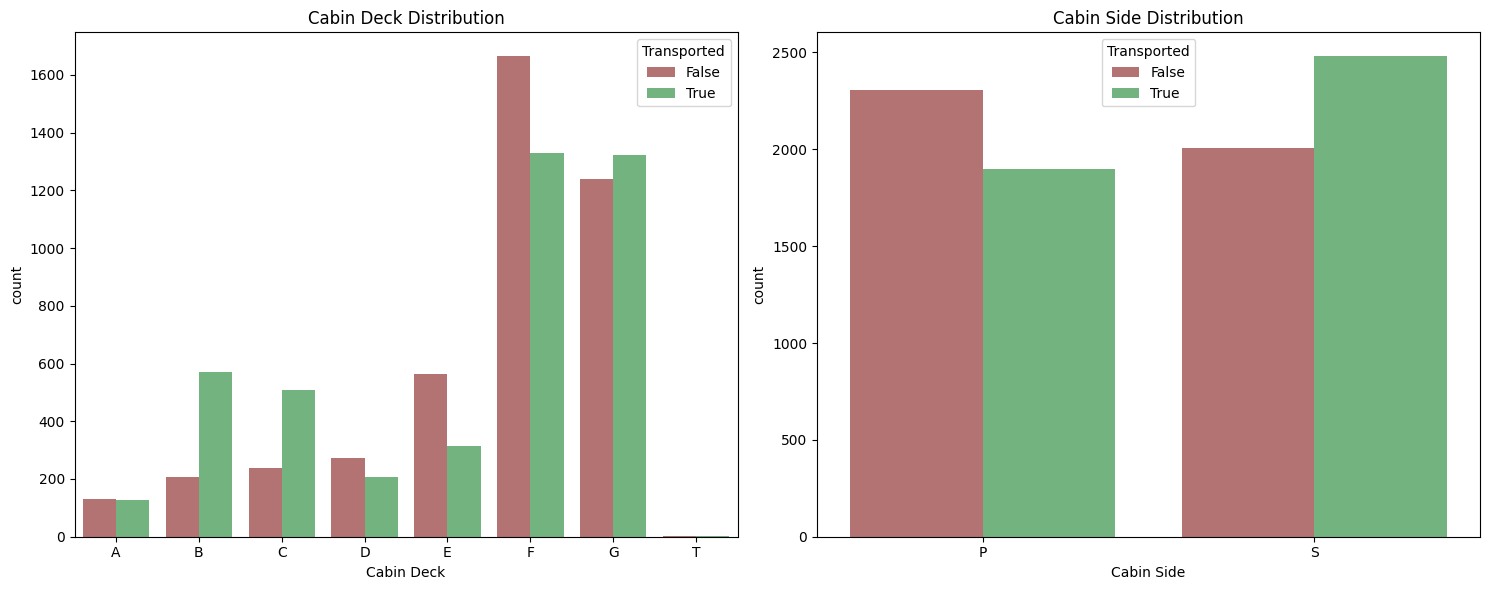

In [22]:
# Visualizing "Cabin Deck" and "Cabin Side" features
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x="Cabin Deck", data=train_df, hue="Transported", palette=color_pallete, order=["A", "B", "C", "D", "E", "F", "G", "T"])
plt.title("Cabin Deck Distribution")
plt.tight_layout()
plt.subplot(1,2,2)
sns.countplot(x="Cabin Side", data=train_df, hue="Transported", palette=color_pallete)
plt.title("Cabin Side Distribution")
plt.tight_layout()